In [1]:
from typing import Dict
from copy import deepcopy
from tqdm import tqdm

import random
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("train.csv", index_col=0)
data.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
Id,,,,,,,,,,,,
0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


In [3]:
data.describe()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,45.800900,1.974800,1702.440000,1.724300,0.37060,0.121500,0.117200,0.059100,0.02770,0.018000,64.435200,0.110900
std,8.030274,1.766883,523.789062,0.798845,0.48299,0.326724,0.321675,0.235824,0.16412,0.132958,13.595024,0.314024
min,23.000000,0.000000,200.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,33.000000,0.000000
25%,40.000000,0.000000,1300.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,55.000000,0.000000
50%,46.000000,2.000000,1550.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,63.000000,0.000000
75%,51.000000,3.000000,2150.000000,2.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,74.000000,0.000000
max,68.000000,9.000000,3950.000000,4.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,100.000000,1.000000


In [4]:
x_train, x_valid = train_test_split(
    data, train_size=7500, random_state=1
)
x_train = x_train.reset_index(drop=True)
x_valud = x_valid.reset_index(drop=True)

y_train, y_valid = x_train["choose"], x_valid["choose"]

In [5]:
to_drop = ["choose"]
x_train = x_train.drop(to_drop, axis=1)
x_valid = x_valid.drop(to_drop, axis=1)

In [6]:
y_train.value_counts()

0    6648
1     852
Name: choose, dtype: int64

In [7]:
xgb_train = xgb.DMatrix(
    data=x_train, label=y_train
)
xgb_valid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [8]:
def init_population(number_of_parents: int) -> Dict[str, np.array]:
    """
    Инициализация начальной популяции генетического алгоритма.

    Parameters
    ----------
    number_of_parents: int
        Количество родителей в популяции.

    Returns
    -------
    population: dict, Dict[str, np.array]
        Словарь с начальной популяцией.

    """
    population = {
        "max_depth": np.empty([number_of_parents, 1], dtype=np.uint8),
        "min_child_weight": np.empty([number_of_parents, 1], dtype=np.uint8),
        "subsample": np.empty([number_of_parents, 1]),
        "colsample_bytree": np.empty([number_of_parents, 1]),
        "gamma": np.empty([number_of_parents, 1])
    }

    for i in range(number_of_parents):
        population["max_depth"][i] = round(
            random.randrange(1, 10, step=1)
        )
        population["min_child_weight"][i] = round(
            random.uniform(0.01, 10), 2
        )
        population["subsample"][i] = round(
            random.uniform(0.01, 1), 2
        )
        population["colsample_bytree"][i] = round(
            random.uniform(0.01, 1), 2
        )
        population["gamma"][i] = round(
            random.uniform(0.01, 10), 2
        )
    return population

In [9]:
def train_population(population,
                     xgb_train: xgb.DMatrix,
                     xgb_valid: xgb.DMatrix,
                     y_valid: pd.Series
                     ):
    """
    Обучение модели на каждом значении population.
    После обучения модели, производится оценка качества
    модели с помощью метрики ROC-AUC на данных xgb_valid.

    Parameters
    ----------
    population: numpy.array
        Матрица с текущим значением популяции.

    xgb_train: xgb.DMatrix
        Выборка для обучения модели, в формате xgboost.DMatrix.

    xgb_valid: xgb.DMatrix
        Выборка для тестирования модели, в формате xgboost.DMatrix.

    y_valid: pd.Series
        Значение целевой переменной для тестирования модели.

    Returns
    -------
    scores: List[float]
        Список со значеним метрик качества.

    """
    scores = []
    for i in range(population.shape[0]):
        xgb_params = {
            "booster": "gbtree",
            "objective": "binary:logistic",
            "learning_rate": 0.1,
            "max_depth": int(population[i][0]),
            "min_child_weight": population[i][1],
            "subsample": population[i][2],
            "colsample_bytree": population[i][3],
            "gamma": population[i][4],
            "eval_metric": "auc",
            "nthread": 6,
            "seed": 27
        }
        model = xgb.train(
            params=xgb_params,
            dtrain=xgb_train,
            evals=[(xgb_train, "train"), (xgb_valid, "valid")],
            early_stopping_rounds=50,
            num_boost_round=1000,
            verbose_eval=25,
        )
        y_pred = model.predict(xgb_valid)
        score = roc_auc_score(y_valid, y_pred)
        scores.append(score)
        print("="*84)

    return scores

In [10]:
def select_new_parents(population: np.array, scores: list, num_parents: int):
    """
    Выбор оптимальный параметров популяции на основе
    значений метрики качества ROC-AUC.

    Parameters
    ----------
    population: np.array
        Матрица с текущим значением популяции.

    scores: List[float]
        Список со значениями метрики качества.

    num_parents: int
        Количество родителей, которые требуется отобрать.

    Returns
    -------
    selected_parents: np.array
        Значение популяции, отобранное на основе метрики качества.

    """
    scores = deepcopy(scores)
    selected_parents = np.empty((
        num_parents, population.shape[1]
    ))

    for parent_id in range(num_parents):
        best_result_id = np.where(scores == np.max(scores))
        best_result_id = best_result_id[0][0]

        selected_parents[parent_id, :] = population[best_result_id, :]
        scores[best_result_id] = -1

    return selected_parents

In [12]:
def crossover_uniform(parents, children_size):
    """
    
    """
    idx_1 = np.arange(
        0, np.uint8(children_size[1]), 1, dtype=np.uint8
    )
    
    idx_2 = []

    for i in range(children_size[1]):
        if i % 4 == 0:
            idx_2.append(i)
            if i+1 >= children_size[1]:
                break
            idx_2.append(i+1)
    np.array(idx_2)
            
    #idx_2 = np.random.randint(
    #    0, np.uint8(children_size[1]), np.uint(children_size[1]/2)
    #)
      
    idx_3 = np.array(
        list(set(idx_1) - set(idx_2))
    )
    children = np.empty(children_size)

    for i in range(children_size[0]):
        parent1_idx = i % parents.shape[0]
        parent2_idx = (i+1) % parents.shape[0]

        children[i, idx_2] = parents[parent1_idx, idx_2]
        children[i, idx_3] = parents[parent2_idx, idx_3]
        

    return children

In [13]:
def mutation(crossover, number_of_parameters):
    """
    Мутация объектов популяции, получение новых значений
    гиперпараметров для проверки гипотезы о повышении качества
    работы модели.

    Parameters
    ----------
    crossover: np.array
        Исходные объекты популяции.

    number_of_parameters: int
        Количество параметров.

    Returns
    -------
    crossover: np.array
        Мутированные объекты популяции.

    """
    min_max_values = np.zeros((number_of_parameters, 2))

    min_max_values[0, :] = [1, 15] # ограничение для max_depth
    min_max_values[1, :] = [0, 10] # ограничение для min_child_weight
    min_max_values[2, :] = [0.01, 1] # ограничение для subsample
    min_max_values[3, :] = [0.01, 1] # ограничение для colsample_bytree
    min_max_values[4, :] = [0.01, 10] # ограничение для gamma
    parameter_selected = np.random.randint(0, 5, 1)

    if parameter_selected == 0:
        mutation_value = np.random.randint(-5, 5, 1)
    elif parameter_selected == 1:
        mutation_value = round(np.random.uniform(5, 5), 2)
    elif parameter_selected == 2:
        mutation_value = round(np.random.uniform(-0.5, 0.5), 2)
    elif parameter_selected == 3:
        mutation_value = round(np.random.uniform(-0.5, 0.5), 2)
    elif parameter_selected == 4:
        mutation_value = round(np.random.uniform(-2, 2), 2)

    for idx in range(crossover.shape[0]):
        crossover[idx, parameter_selected] = crossover[idx, parameter_selected] + mutation_value
        if crossover[idx, parameter_selected] > min_max_values[parameter_selected, 1]:
            crossover[idx, parameter_selected] = min_max_values[parameter_selected, 1]
        else:
            crossover[idx, parameter_selected] = min_max_values[parameter_selected, 0]

    return crossover

In [14]:
number_of_parents = 8
number_of_parents_mating = 4
number_of_parameters = 5
number_of_generation = 6

population_size = (number_of_parents, number_of_parameters)
scores_history = np.empty([number_of_generation+1, number_of_parents])

params_history = np.empty([(number_of_generation+1) * number_of_parents, number_of_parameters])

In [15]:
population = init_population(number_of_parents)

population = np.concatenate((
    population["max_depth"],
    population["min_child_weight"],
    population["subsample"],
    population["colsample_bytree"],
    population["gamma"]), axis=1)

params_history[0:number_of_parents, :] = population

In [16]:
for generation in tqdm(range(number_of_generation)):
    best_score, mean_score = np.max(scores_history), np.mean(scores_history)
    print(f"All-history: Best ROC-AUC = {round(best_score, 4)}, Mean ROC-AUC = {round(mean_score, 4)}")

    scores = train_population(
        population=population,
        xgb_train=xgb_train,
        xgb_valid=xgb_valid,
       y_valid=y_valid)

    scores_history[generation, :] = scores

    parents = select_new_parents(
        population=population,
        scores=scores,
        num_parents=4)

    children = crossover_uniform(
        parents=parents,
        children_size=(population_size[0] - parents.shape[0], 5)
    )
    children_mutated = mutation(children, number_of_parameters=5)
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]:, :] = children_mutated

    params_history[(generation+1)*8 : (generation+1)*8+8 , :] = population
    clear_output()

scores_history = pd.DataFrame(scores_history)
scores_history = scores_history.loc[:5]

100%|██████████| 6/6 [00:42<00:00,  7.05s/it]


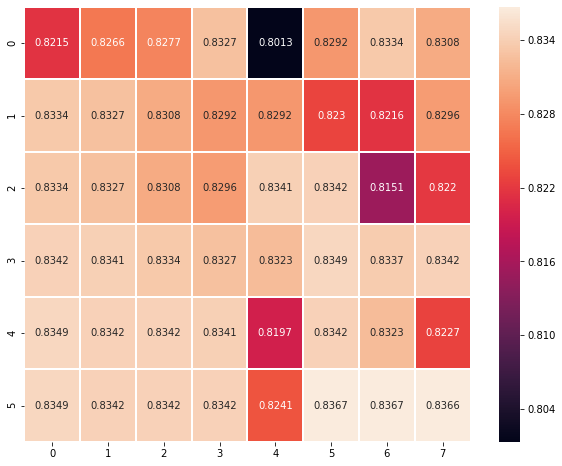

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(scores_history, annot=True, fmt='.4g', linewidths=1, ax=axes)

**Пояснение к домашнему заданию**

Я реализовал механизм Многоточечного кроссовера. Для того, чтобы он заработал я заменил в исходном коде всего 1 часть:

**Было:**
 idx_2 = np.random.randint(
        0, np.uint8(children_size[1]), np.uint(children_size[1]/2)
    )
    
**Стало:**
 idx_2 = []

    for i in range(children_size[1]):
    
        #каждое число кратное 4 мы записываем, как 0 и 0+1, затем кратность сработает через 2 и берем 4 и 4+1 и т.д.
        
        if i % 4 == 0: 
            idx_2.append(i)
            if i+1 >= children_size[1]:
                break
            idx_2.append(i+1)
            
    np.array(idx_2)
    
 Если захотим брать по три числа подряд то пишем кратность if i % 5 == 0: и 
 еще 1 этаж:
 
     if i+1 >= children_size[1]:
                break
            idx_2.append(i+1)
